# Optimizing Player Retention through A/B Testing in Mobile Games

## Business Use Case

Cookie Cats is a highly popular mobile puzzle game created by Tactile Entertainment. It's a classic "connect three" puzzle game where players must connect tiles of the same color to clear the board and complete levels. The game also features singing cats, which adds a unique and entertaining element.

As players advance through the game, they encounter gates that require them to wait for a certain period or make an in-app purchase to continue. In this project, we will examine the results of an A/B test in which the first gate in Cookie Cats was moved from level 30 to level 40. Specifically, we will analyze how this change affected player retention and the number of game rounds played.

## Importing the Packages

In [1]:
# Data Analysis and Visualization Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Hypothesis Testing Libraries

from scipy.stats import shapiro
import scipy.stats as stats

# Configuration and Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# File Operations
import os

## Importing Data

In [2]:
game_data = pd.read_csv("cookie_cats.csv")
game_data.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Exploratory Data Analysis (EDA)

In [3]:
# Print dimensions
print("Observation:", game_data.shape[0], "Column:", game_data.shape[1], "\n")

Observation: 90189 Column: 5 



In [4]:
# Print Data Types
data_types = ['object', 'int', 'float', 'bool']
type_names = ['Object', 'Integer', 'Float', 'Bool']

for dtype, type_name in zip(data_types, type_names):
    columns = game_data.select_dtypes(dtype).columns
    if len(columns) > 0:
        print(f"{type_name} Variables:", "\n", f"No. of Variables: {len(columns)}", "\n", columns.tolist(), "\n")


Object Variables: 
 No. of Variables: 1 
 ['version'] 

Integer Variables: 
 No. of Variables: 2 
 ['userid', 'sum_gamerounds'] 

Bool Variables: 
 No. of Variables: 2 
 ['retention_1', 'retention_7'] 



In [5]:
# Missing Values

if game_data.isnull().values.any():
    print("Data includes missing values!")
else:
    print("No missing values!")

No missing values!


## Analysis & Visualization

In [6]:
# Check for duplicate users
if game_data.userid.nunique() == game_data.shape[0]:
    print("No duplicate rows: Each user ID is unique.")
else:
    print("Duplicate rows exist: Some user IDs are repeated.")

No duplicate rows: Each user ID is unique.


In [7]:
# Summary Statistics for sum_gamerounds column

game_data.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,49854.0


In [8]:
# A/B Groups & Target Summary Statistics

game_data.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


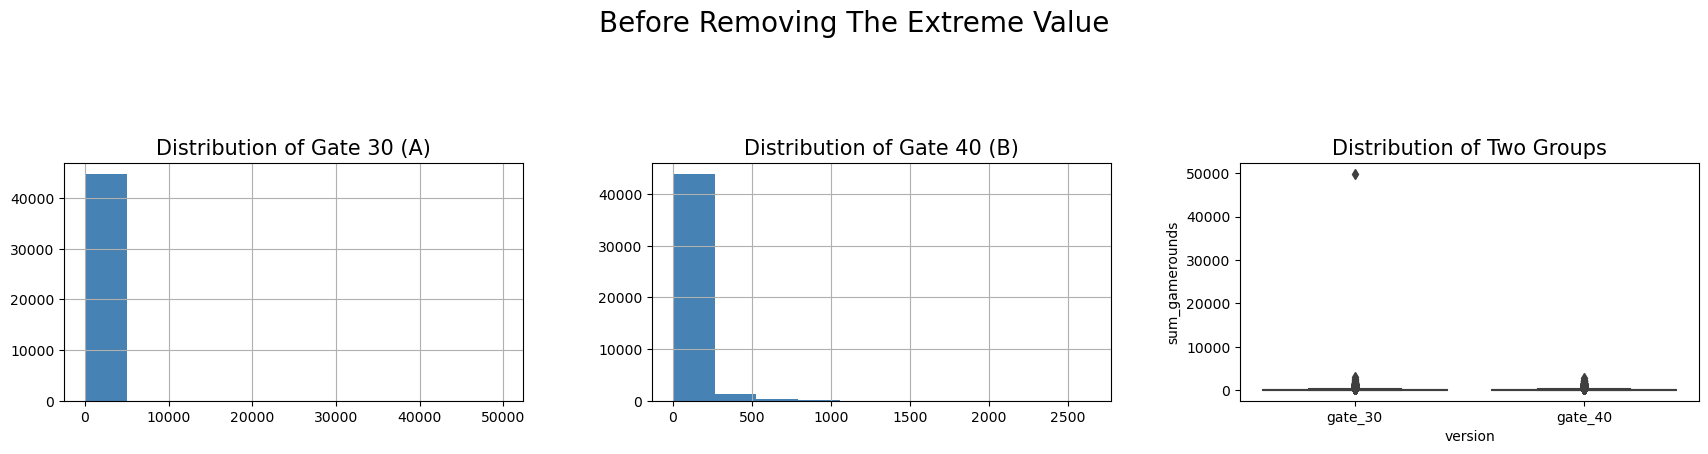

In [9]:
# Histograms and Boxplot

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot histograms and boxplot
for version, ax, title in zip(["gate_30", "gate_40"], axes[:2], ["Distribution of Gate 30 (A)", "Distribution of Gate 40 (B)"]):
    game_data[game_data.version == version].hist("sum_gamerounds", ax=ax, color="steelblue")
    ax.set_title(title, fontsize=15)

# Plot boxplot
sns.boxplot(x="version", y="sum_gamerounds", data=game_data, ax=axes[2])
axes[2].set_title("Distribution of Two Groups", fontsize=15)

# Set overall title and adjust layout
plt.suptitle("Before Removing The Extreme Value", fontsize=20)
plt.tight_layout(pad=4)


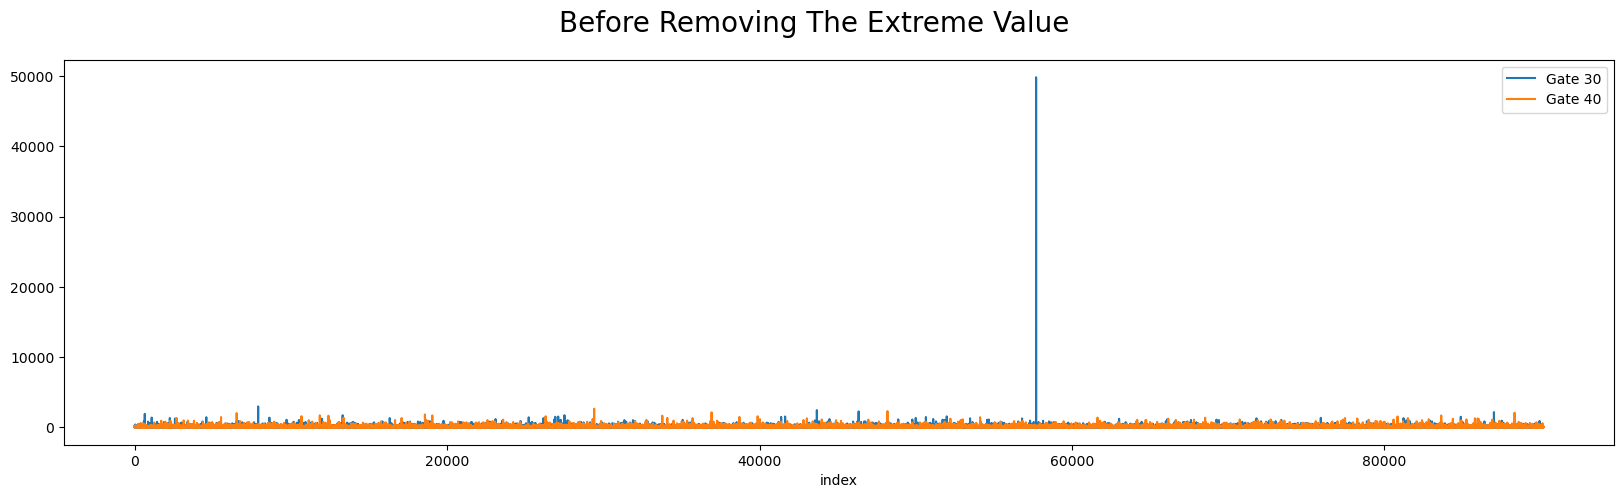

In [10]:
# Line Plot for sum_gamerounds

# Plot sum_gamerounds for both versions
for version, label in [("gate_30", "Gate 30"), ("gate_40", "Gate 40")]:
    subset = game_data[game_data.version == version]
    subset.reset_index().set_index("index").sum_gamerounds.plot(legend=True, label=label, figsize=(20, 5) if version == "gate_30" else None)

# Set title
plt.suptitle("Before Removing The Extreme Value", fontsize=20)
plt.legend()
plt.show()

In [11]:
## Treating Outliers

# Filter out extreme values in the 'sum_gamerounds' column
game_data = game_data[game_data.sum_gamerounds < game_data.sum_gamerounds.max()]

In [12]:
# Compute and print summary statistics for the filtered data

summary_stats = game_data.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T
summary_stats

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0,51.320253,102.682719,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,2961.0


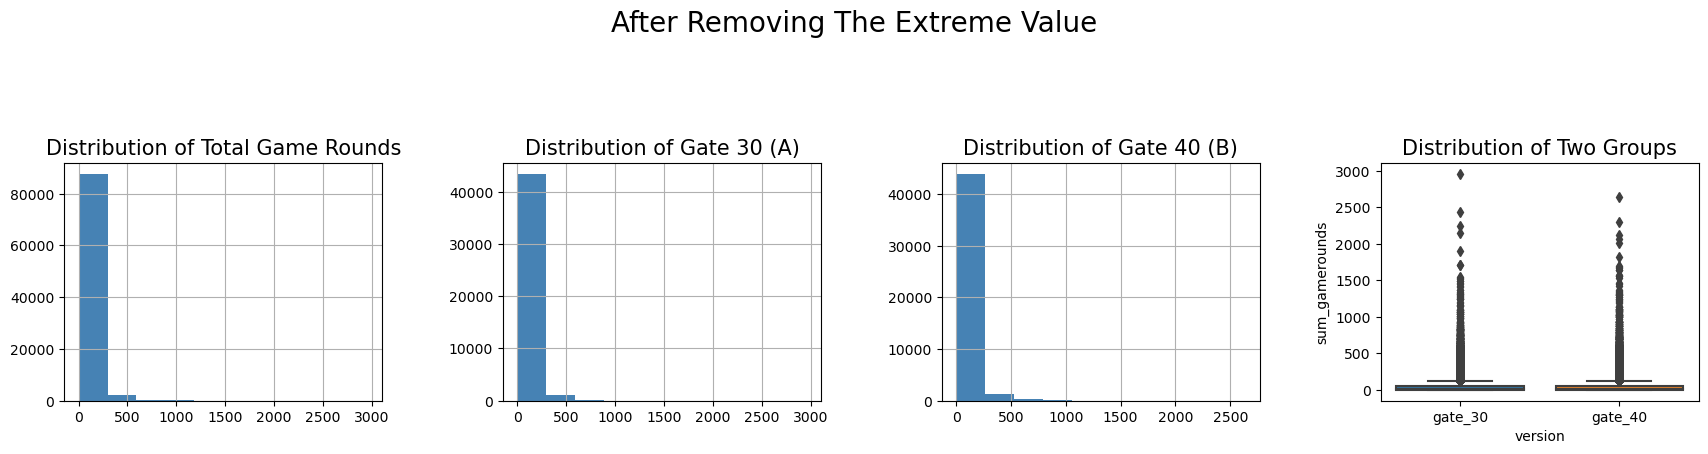

In [13]:
# Distribution Plots

# Create subplots for visualizing distributions
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Plot histogram of total game rounds
game_data.sum_gamerounds.hist(ax=axes[0], color="steelblue")
axes[0].set_title("Distribution of Total Game Rounds", fontsize=15)

# Plot histogram for 'gate_30' version
game_data[game_data.version == "gate_30"].hist("sum_gamerounds", ax=axes[1], color="steelblue")
axes[1].set_title("Distribution of Gate 30 (A)", fontsize=15)

# Plot histogram for 'gate_40' version
game_data[game_data.version == "gate_40"].hist("sum_gamerounds", ax=axes[2], color="steelblue")
axes[2].set_title("Distribution of Gate 40 (B)", fontsize=15)

# Plot boxplot for comparing distributions of both versions
sns.boxplot(x="version", y="sum_gamerounds", data=game_data, ax=axes[3])
axes[3].set_title("Distribution of Two Groups", fontsize=15)

# Set overall title and adjust layout
plt.suptitle("After Removing The Extreme Value", fontsize=20)
plt.tight_layout(pad=4)

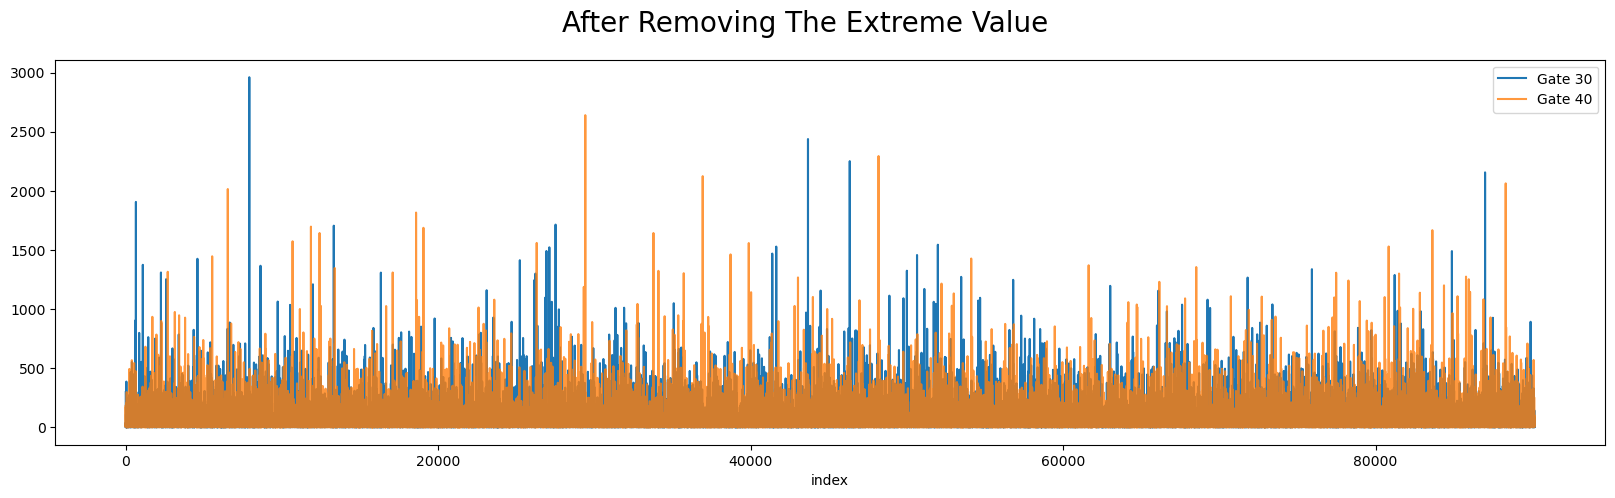

In [14]:
game_data[(game_data.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
game_data[game_data.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("After Removing The Extreme Value", fontsize = 20);

## Discussions

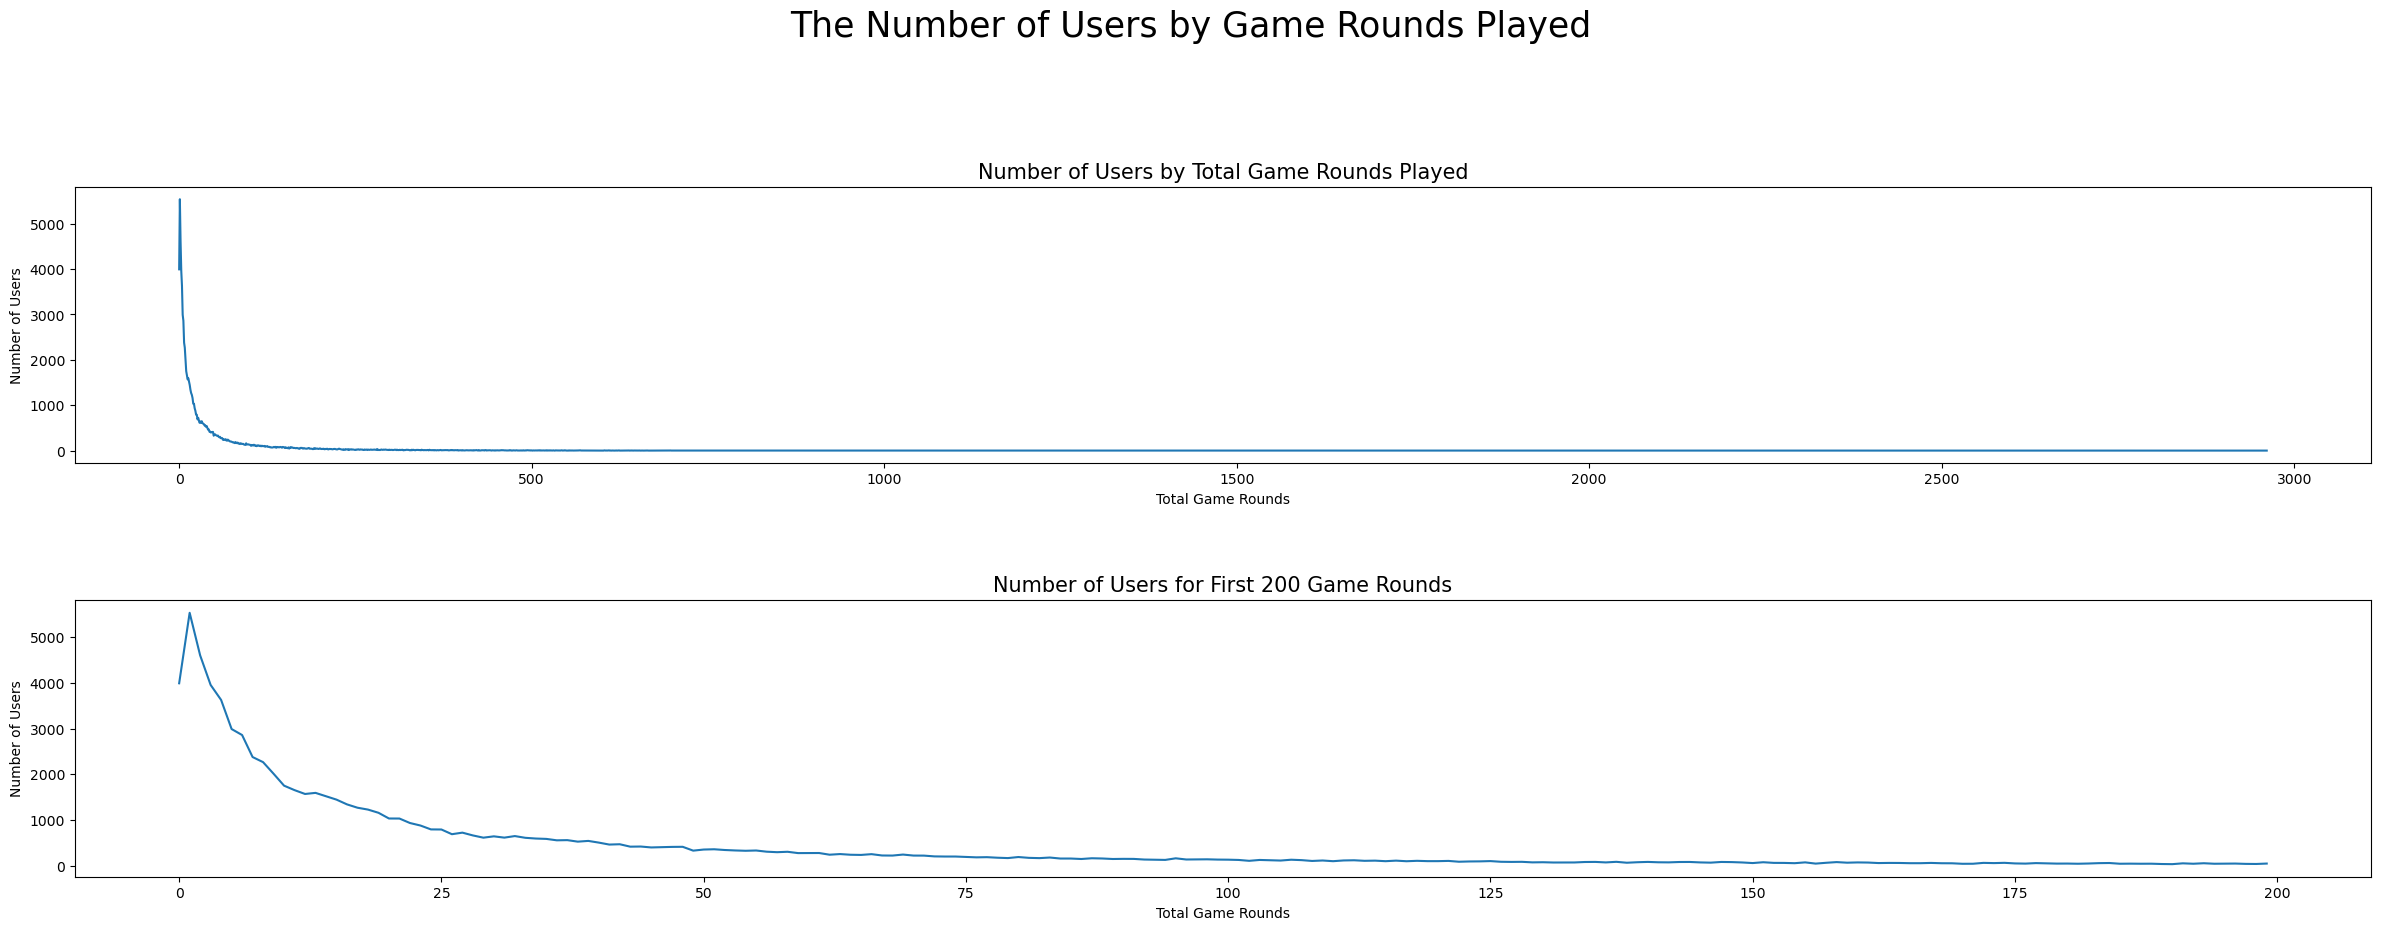

In [15]:
import matplotlib.pyplot as plt

# Create subplots with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(25, 10))

# Plot the number of users for each value of sum_gamerounds
game_data.groupby("sum_gamerounds").userid.count().plot(ax=axes[0])
axes[0].set_title("Number of Users by Total Game Rounds Played", fontsize=15)
axes[0].set_xlabel("Total Game Rounds")
axes[0].set_ylabel("Number of Users")

# Plot the number of users for the first 200 values of sum_gamerounds
game_data.groupby("sum_gamerounds").userid.count()[:200].plot(ax=axes[1])
axes[1].set_title("Number of Users for First 200 Game Rounds", fontsize=15)
axes[1].set_xlabel("Total Game Rounds")
axes[1].set_ylabel("Number of Users")

# Overall title and layout adjustment
plt.suptitle("The Number of Users by Game Rounds Played", fontsize=25)
plt.tight_layout(pad=5)
plt.show()


In [16]:
game_data.groupby("sum_gamerounds").userid.count().reset_index().head(10)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [17]:
# How many users reached gate 30 & gate 40 levels?
game_data.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

**We can see that by looking at the summary statistics, the control and Test groups seem similar, but we will investigate this statistically.**

In [18]:
# A/B Groups & Target Summary Stats
game_data.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961
gate_40,45489,16.0,51.298776,103.294416,2640


In [19]:
# Check the retention level

pd.DataFrame({"RET1_COUNT": game_data["retention_1"].value_counts(),
              "RET7_COUNT": game_data["retention_7"].value_counts(),
              "RET1_RATIO": game_data["retention_1"].value_counts() / len(game_data),
              "RET7_RATIO": game_data["retention_7"].value_counts() / len(game_data)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.554786,0.813944
True,40153,16780,0.445214,0.186056


**Looking at the summary statistics of retention variables by version and comparing with sum_gamerounds, there are similarities between groups. However, it will be more helpful to see if there is a statistically significant difference.**

In [20]:
game_data.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median       mean         std   max
version retention_1                                            
gate_30 False        24665     6.0  16.359092   36.528426  1072
        True         20034    48.0  94.411700  135.037697  2961
gate_40 False        25370     6.0  16.340402   35.925756  1241
        True         20119    49.0  95.381182  137.887256  2640

In [21]:
game_data.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention_7                                             
gate_30 False        36198    11.0   25.796508   43.316158   981
        True          8501   105.0  160.117516  179.358560  2961
gate_40 False        37210    11.0   25.856356   44.406112  2640
        True          8279   111.0  165.649837  183.792499  2294

**Approximately 12.000 users among the total users played the game both 1 day and 7 days after installing the game. 14% of the total users include people who will continue the game in the future.**

In [22]:
game_data["Retention"] = np.where((game_data.retention_1 == True) & (game_data.retention_7 == True), 1,0)

game_data.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version Retention                                             
gate_30 0          38023    12.0   28.070273   48.017452  1072
        1           6676   127.0  183.886309  189.626390  2961
gate_40 0          38983    12.0   28.103353   48.927850  2640
        1           6506   133.0  190.282355  194.220077  2294

In [23]:
game_data["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), game_data.retention_1, game_data.retention_7))
game_data.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22840,6.0,11.819746,21.642643,981
1,gate_30,False-True,1825,43.0,73.169315,93.222330,1072
2,gate_30,True-False,13358,33.0,49.694490,58.125396,918
3,gate_30,True-True,6676,127.0,183.886309,189.626390,2961
4,gate_40,False-False,23597,6.0,11.913294,20.901020,547
5,gate_40,False-True,1773,47.0,75.261139,94.478048,1241
6,gate_40,True-False,13613,32.0,50.025490,60.924587,2640
7,gate_40,True-True,6506,133.0,190.282355,194.220077,2294


## A/B Testing


### Null Hypothesis H0 --> The Groups Are Similar
### Alternate Hypothesis H1 --> The Groups are not similar

### Tests to be conducted

- Shapiro-Wilk Test: Use to check if the data is normally distributed.
- Levene's Test: Use to check if the variances between groups are equal.
- T-Test (Parametric): Use when data is normally distributed and variances are equal or when heteroscedasticity is accounted for.
- Mann-Whitney U Test (Non-Parametric): Use when data is not normally distributed.

In [24]:
# Define A/B groups
game_data["version"] = np.where(game_data.version == "gate_30", "A", "B")
game_data.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [25]:
# A/B testing function

def ABTest(dataframe, group, target):
    
    # Splitting Data into Groups A and B
    groupA_data = dataframe[dataframe[group] == "A"][target]
    groupB_data = dataframe[dataframe[group] == "B"][target]
    
    # Normality Test
    is_normal_A = shapiro(groupA_data)[1]  < 0.05
    is_normal_B = shapiro(groupB_data)[1] < 0.05
    
    # Checks if data in each group is normally distributed using the Shapiro-Wilk test.
    # If p-value >= 0.05, the data is normally distributed.
    
    # If both groups fail the normality test (i.e., non-normal distribution), 
    # the function proceeds with a parametric test; otherwise, it uses a non-parametric test.
    
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (is_normal_A == False) & (is_normal_B == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        
        is_homogeneous = stats.levene(groupA_data, groupB_data)[1] < 0.05
        # H0: Homogeneity: True
        # H1: Heterogeneous: False
        
        # T-test compares means Equal variances (if Levene's test indicates homogeneity). 
        # Unequal variances (if Levene's test indicates heterogeneity).
        
        if is_homogeneous:
            # Homogeneity
            ttest_result = stats.ttest_ind(groupA_data, groupB_data, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest_result = stats.ttest_ind(groupA_data, groupB_data, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest_result = stats.mannwhitneyu(groupA_data, groupB_data)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result Compilation
    result_summary = pd.DataFrame({
        "AB Hypothesis": [ttest_result < 0.05],  
        "p-value": [ttest_result],
        "Significance Value" : 0.05
    })
    
    # Specifies whether a parametric or non-parametric test was used.
    result_summary["Test Type"] = np.where(not (is_normal_A and is_normal_B), "Parametric", "Non-Parametric")
    
    # Indicates whether to reject the null hypothesis based on the p-value.
    result_summary["AB Hypothesis"] = np.where(result_summary["AB Hypothesis"], "Reject H0", "Fail to Reject H0")
    
    # Provides a brief interpretation of the results
    result_summary["Comment"] = np.where(result_summary["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Additional Details for Parametric Test:
    if not (is_normal_A and is_normal_B):
        result_summary["Homogeneity"] = np.where(is_homogeneous, "Yes", "No")
        result_summary = result_summary[["Test Type", "Homogeneity", "AB Hypothesis", "p-value", "Significance Value", "Comment"]]
    else:
        result_summary = result_summary[["Test Type", "AB Hypothesis", "p-value", "Significance Value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return result_summary


In [26]:
# Apply A/B Testing
ABTest(dataframe=game_data, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Significance Value,Comment
0,Non-Parametric,Fail to Reject H0,0.050892,0.05,A/B groups are similar!


## Summary of A/B Testing

- Performed A/B testing on a dataset to compare two groups.
- Test for normality of the data and decide on the appropriate statistical test.
- Used a t-test if data is normally distributed or a Mann-Whitney U test if not.
- Output results including whether the null hypothesis is rejected and provide a summary of the test used.

## Conclusion

Based on the analysis, the p-value obtained is 0.050892, which is slightly above the significance level of 0.05. Therefore, we fail to reject the null hypothesis. This indicates that, given the data, there is not sufficient evidence to conclude that there is a statistically significant difference between Group A and Group B. While the null hypothesis (A = B) remains a plausible explanation, it is important to note that this result does not prove the null hypothesis to be true. It simply means that the evidence from this test does not strongly support the alternative hypothesis (A ≠ B).